In [1]:
#=============================================================================
# class Cell
# usage: scr = Screen('Neurons',4,10)
#        cell = Cell(nr.at(1,2),k,g,K,P)
#        cell.show()
#=============================================================================

from carabao.screen import Screen
import torch
import numpy

class Cell:
    def __init__(self,screen,k,g,K,P):
        self.at(screen)
        self.config(k,g,K,P)
        self.x = 0          # x(0), or in general: x(t+1)
        self.P = P          # P(0), or in general: P(t+1)
        self.invalid('x,y,u,b,p,l,c,q')
        self.verbose = 0    # verbose mode disabled
        self.iteration = 0
        
    def config(self,k,g,K,P):
        nan = float('nan')
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
        self.pdelta = 0.04  # positive learning delata
        self.ndelta = 0.02  # negative learning delta
        self.k = k;
        self.g = g;  
        self.K = K;
        self.P = P*nan
        self.Q = None
        self.L = None       # boolean learning matrix
        self.D = None       # permanence learning delta
        self.W = K*nan
        self.Z = K*nan
        self.q = nan
    
    def input(self,u,c):           # update input
        self.invalid('Q,L,D')       # invalidate

            # excited (u=1) & predictive (x=1) cells get active (y=1)
        
        self.u = u                 
        self.y = self.u * self.x   # excited & predictive cells get active

            # update context c[k] with updated output y
        
        c[self.k] = self.y         # update context with changed output
        self.c = c                 # store c in cell

            # log key quantities if verbose
        
        if self.verbose > 0:
            self.log("(input)")
            
        return self.c              # return updated context
        
    def context(self,c):           # process context
        self.c = c
        self.b = self.burst(c)

            # second chance: an excited bursting cell gets active 
        
        self.y = self.u * (self.y if self.b == 0 else 1)
        c[self.k] = self.y

            # process W,Z,Q,L,D
        
        self.W = (self.P >= self.eta)
        self.Z = self.select(c,self.K)
        Q = torch.mul(self.Z,self.W)  # synapitcs matrix

        l,L,p = self.learn(Q)
        D = self.y * (L*Q*self.pdelta - L*self.ndelta)

            # calculate state & permanences after transition
        
        spike = L.any().item()             # predictive spike 
        self.x_ = self.u * spike           # getting predictive
        self.P_ = self.P + D               # learning

            # save this stuff

        self.L = L;  self.D = D;  self.Q = Q;  self.l = l;  self.p = p;

        self.transition()
        return c

    def place(self,screen,ij):
        self.screen = screen
        self.ij = ij

    def at(self,screen):
        if screen != None:
            self.place(screen,screen.ij)

    def select(self,c,K):
        self.Z = 0*K
        for mu in range(0,K.size(0)):
            for nu in range(0,K.size(1)):
                self.Z[mu,nu] = c[K[mu,nu]];
        return self.Z

    def norm(self,M):    # max of column sums
        result = 0
        for j in range(0,M.size(0)):
            sumj = M[j].sum().item()
            result = result if sumj < result else sumj
        return result
            
    def transition(self):              # state & permanence transition
        self._x = self.x               # save x(t) in history x(t-1)
        self._y = self.y               # save y(t) in history y(t-1)
        
        self.x = self.x_               # state transition
        self.P = self.P_               # permanence transition

        self.x_ = float('nan')         # invalidate
        self.P_ = float('nan')         # invalidate

        if self.verbose > 0:
            self.log("(context)")
        
        self.invalid('b,p,l,W,Z')       # invalidate
        self.iteration += 1


    def burst(self,c):
        self.q = []
        for k in range(0,len(self.g)):
           qk = c[self.g[k]]
           self.q.append(qk)
        b = (sum(self.q) == 0)               # burst signal
        return int(b)

    def learn(self,Q):                       # learning vector
        d,s = Q.size()
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(Q[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = torch.tensor([p]).t()*torch.ones(1,s)
        return l,L,p

    def invalid(self,tag):           # set some items equal to nan
        nan = float('nan');
        if tag == 'b,p,l,W,Z':
            self.b = nan            # at this phase no burst signal needed
            self.p = nan            # at this phase no post s. effect needed
            self.l = nan            # at this phase no learning vector needed
            self.W = self.W*nan     # no weights needed
            self.Z = self.Z*nan     # no pre-synaptic signals needed
        elif tag == 'x,y,u,b,p,l,c,q':
            self.y = nan
            self.u = nan
            self.b = nan            # burst signal
            self.p = nan            # post synaptic effect
            self.l = nan
            self.c = nan
            self.q = nan 
            self.y_ = nan
            self._x = nan
            self._y = nan
        elif tag == 'Q,L,D':
            #self.Q = None           # no synaptics
            self.L = None           # no binary learning matrix
            self.D = None           # no learning deltas
        
    def valid(self,arg):            # check if arg has valid numbers
        isnan = numpy.isnan(arg).any()
        return isnan == False
        
    def clone(self,screen):
        self.screen = screen
        return self

    def plot(self,i=None,j=None):
        if i != None:
            self.place(self.screen,(i,j))
        self.screen.cell(self.ij,self.x,self.y,self.P,self.Q,self.L)
        self.screen.input(self.ij[1],self.u)
        self.screen.show

    def show(self,i=None,j=None):
        if i != None:
            self.plot(i,j)
        can = self.neurons.canvas()
        self.plot()

    def print(self,tag,msg,arg):   # .print("matrix","Q:",Q)
        if tag == 'matrix':
            m,n = arg.size()
            print(msg,"[",end='')
            sepi = ''
            for i in range(0,m):
                print(sepi,end='');  sepi = '; ';  sepj = ''
                for j in range(0,n):
                    s = "%4g" % arg[i,j].item()
                    s = s if s[0:2] != '0.' else s[1:]
                    s = s if s[0:3] != '-0.' else '-'+s[2:]
                    print("%5s" % s, end=''); 
                    sepj = ' '
            print(']')
        elif tag == 'number':
            print(msg,"%4g" % arg)
        
    def log(self,msg=None):
        nan = float('nan')
        msg = msg if msg != None else ""
        print("-------------------------------------------------------------")
        print("iteration: ",self.iteration,msg)
        print("   k:",self.k,", g:",self.g,", eta:",self.eta)
        self.print('matrix',"   K:",self.K)
        self.print('matrix',"   P:",self.P)
        if self.valid(self.W):
            self.print('matrix',"   W:",self.W)
        if self.valid(self.Z):
            self.print('matrix',"   Z:",self.Z)
        if self.Q != None:
            self.print('matrix',"   Q:",self.Q)
        if self.L != None:
            self.print('matrix',"   L:",self.L)
        if self.D != None:
            self.print('matrix',"   D:",self.D)
        if self.valid(self.b):
            print("   b:",self.b,", q:",self.q,
              " (||q||=%g)" % (nan if numpy.isnan(self.q).any() else sum(self.q)))
        if self.valid(self.l):
            print("   l:",self.l,", p:",self.p,
              "(||Q||=max(l)=%g, theta:%g)" % (self.norm(self.Q),self.theta))
        print("   u:",self.u)
        print("   x: %g (was: %g)" % (self.x,self._x))
        print("   y: %g (was: %g)" % (self.y,self._y))
        print("   c:",self.c)
        print("-------------------------------------------------------------")
        


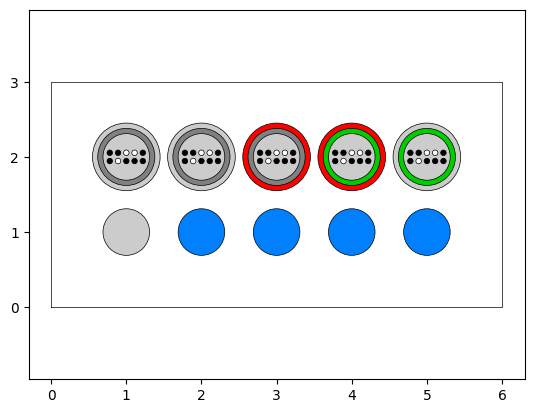

In [2]:
# Setup a cell

g = [0,1,2,3]                # group indices
K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

    # create an inactive neuron

scr = Screen('Neurons',1,5)
cell = Cell(scr,0,g,K,P)
cell.plot()

    # cell excitation

cell.u = 1
cell.plot(0,1)

    # cell activation

cell.y = 1
cell.plot(0,2)

    # predictive state activation

cell.x = 1
cell.plot(0,3)

    # cell deactivation

cell.y = 0
cell.plot(0,4)




-------------------------------------------------------------
iteration:  0 (configured)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: nan
   x: 0 (was: nan)
   y: nan (was: nan)
   c: nan
-------------------------------------------------------------


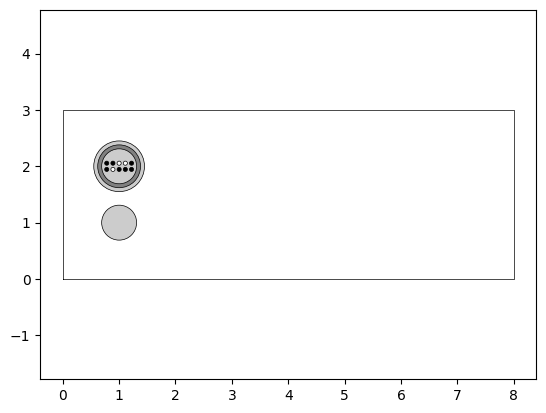

In [3]:
# step 1: create an inactive neuron

c = [0,0,0,0,1,1,1,1,0,1]    # context
scr = Screen('Neurons',1,7)
cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.log("(configured)")
cell.plot()

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


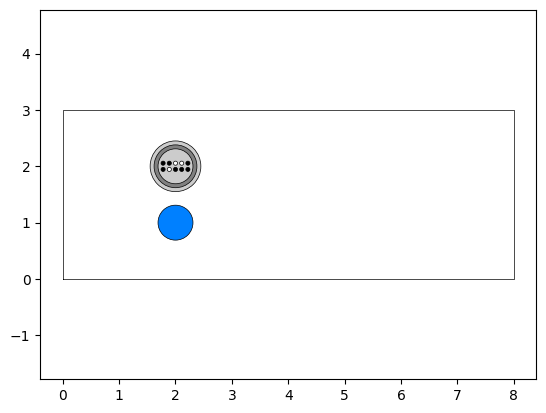

In [4]:
# step 2 / iteration 0: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,1)

-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: [0, 0, 0, 0]  (||q||=0)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


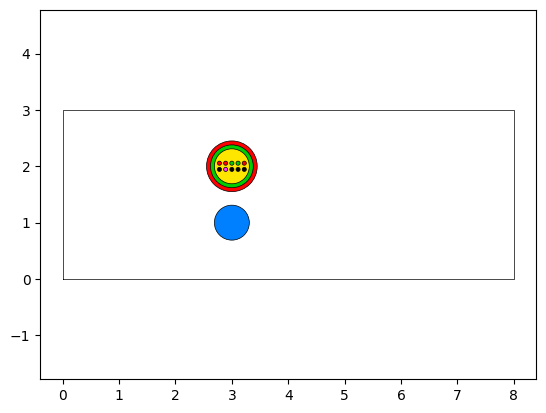

In [5]:
# step 3 / iteration 0: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.context(c)
cell.plot(0,2)

-------------------------------------------------------------
iteration:  1 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


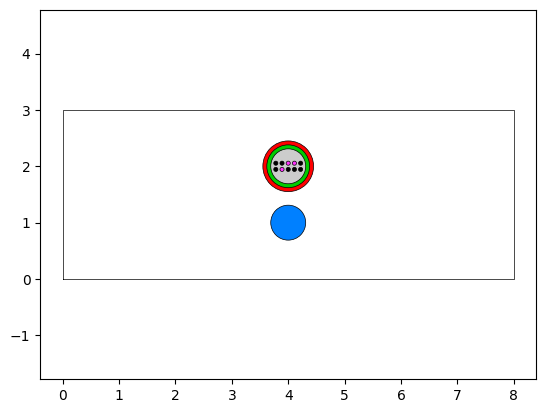

In [6]:
# step 4 / iteration 1: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,3)

-------------------------------------------------------------
iteration:  1 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .08  .28  .58  .81 -.04;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 0 , q: [1, 0, 0, 0]  (||q||=1)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 1)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


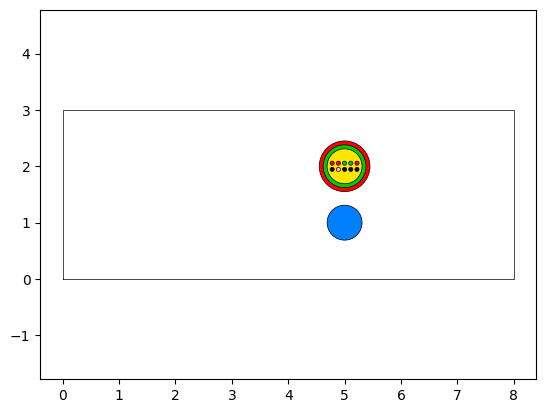

In [15]:
# step 5 / iteration 1: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
cell.context(c)
cell.plot(0,4)

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------
-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: [0, 0, 0, 0]  (||q||=0)
   l: [2, 1] , p: [1, 0] 

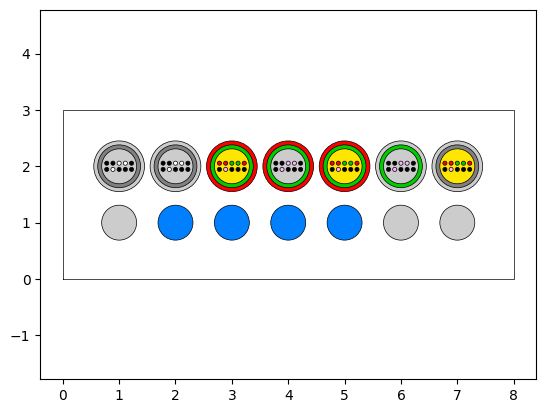

In [16]:
# all together now

    # step 0: create an inactive neuron

scr = Screen('Neurons',1,7)
c = [0,0,0,0,1,1,1,1,0,1]    # context

cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.plot()

    # step 1 / iteration 0: apply input u(t=0) to neuron

c = cell.input(1,c)
cell.plot(0,1)

    # step 2 / iteration 0: apply context c(t=0) to neuron

c = cell.context(c)
cell.plot(0,2)

    # step 3 / iteration 1: apply input u(t=1) to neuron

c = cell.input(1,c)
cell.plot(0,3)

    # step 4 / iteration 1: apply context c(t=1) to neuron

c = cell.context(c)
cell.plot(0,4)

    # step 5 / iteration 2: apply input u(t=2) to neuron

c = cell.input(0,c)
cell.plot(0,5)

    # step 6 / iteration 1: apply context c(t=2) to neuron

c = cell.context(c)
cell.plot(0,6)

